# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.873369,True,7.631441
1,-0.454660,False,-0.983654
2,-0.311393,False,0.568165
3,0.019126,True,5.215282
4,1.232669,True,6.535844
...,...,...,...
995,0.726076,True,5.290686
996,2.311299,True,7.573668
997,-0.193134,False,-0.138724
998,0.898267,True,6.647209


<Axes: xlabel='v0'>

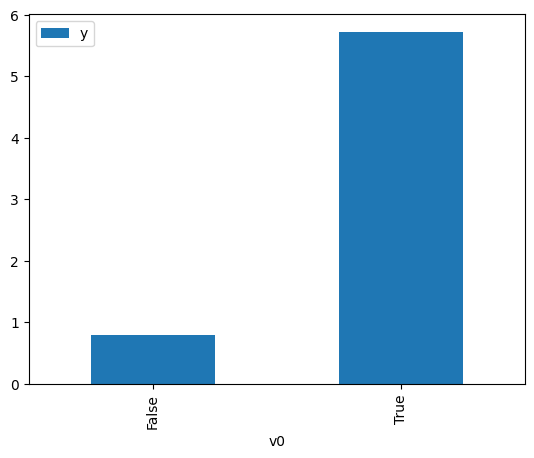

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

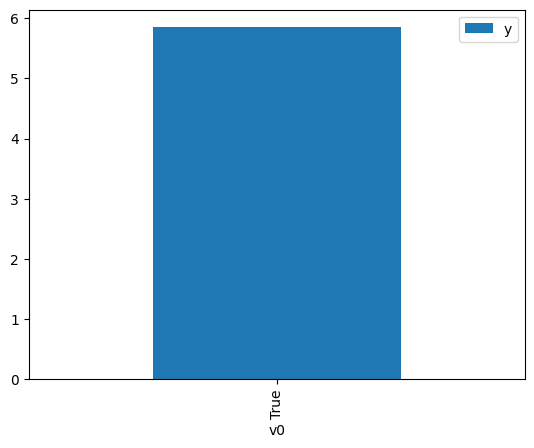

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.516043,False,-0.545623,0.238641,4.190402
1,1.869794,False,2.799745,0.016290,61.388164
2,0.639884,False,-0.523910,0.193230,5.175179
3,-1.049229,False,-0.541982,0.903782,1.106462
4,1.869794,False,2.799745,0.016290,61.388164
...,...,...,...,...,...
995,0.712475,False,2.032263,0.169829,5.888278
996,1.220727,False,0.249688,0.063514,15.744581
997,1.071904,False,0.501629,0.085677,11.671757
998,1.197020,False,-0.285915,0.066647,15.004524


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.612009,True,5.907924,0.797155,1.254462
1,1.468826,True,6.432508,0.961941,1.039565
2,0.839326,True,6.288672,0.865575,1.155301
3,0.724306,True,3.476508,0.833764,1.199380
4,2.489883,True,7.622922,0.995713,1.004306
...,...,...,...,...,...
995,1.144508,True,7.042830,0.925897,1.080033
996,0.680236,True,5.668570,0.820068,1.219410
997,2.639511,True,7.206697,0.996899,1.003111
998,2.316264,True,6.895061,0.993761,1.006278


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                          1.339e+04
Date:                Mon, 27 Nov 2023   Prob (F-statistic):                        0.00
Time:                        17:56:39   Log-Likelihood:                         -1447.7
No. Observations:                1000   AIC:                                      2899.
Df Residuals:                     998   BIC:                                      2909.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9364      0.040     23.444      0.000       0.858       1.015
x2             4.9866      0.060     83.025      0.000       4.869       5.104
==============================================================================
Omnibus:                        1.327   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.515   Jarque-Bera (JB):                1.210
Skew:                          -0.039   Prob(JB):                        0.546
Kurtosis:                       3.152   Cond. No.                         3.15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""